In [1]:
import inspect

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from L96_model import L96_eq1_xdot

print(inspect.getsource(L96_eq1_xdot))

@jit
def L96_eq1_xdot(X, F, advect=True):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 1:
        d/dt X[k] = -X[k-2] X[k-1] + X[k-1] X[k+1] - X[k] + F

    Args:
        X : Values of X variables at the current time step
        F : Forcing term
    Returns:
        dXdt : Array of X time tendencies
    """

    K = len(X)
    Xdot = np.zeros(K)

    if advect:
        Xdot = np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) - X + F
    else:
        Xdot = -X + F
    #     for k in range(K):
    #         Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F
    return Xdot



In [3]:
from L96_model import RK4

print(inspect.getsource(RK4))

def RK4(fn, dt, X, *params):
    """
    Calculate the new state X(n+1) for d/dt X = fn(X,t,...) using the fourth order Runge-Kutta method.

    Args:
        fn     : The function returning the time rate of change of model variables X
        dt     : The time step
        X      : Values of X variables at the current time, t
        params : All other arguments that should be passed to fn, i.e. fn(X, t, *params)

    Returns:
        X at t+dt
    """

    Xdot1 = fn(X, *params)
    Xdot2 = fn(X + 0.5 * dt * Xdot1, *params)
    Xdot3 = fn(X + 0.5 * dt * Xdot2, *params)
    Xdot4 = fn(X + dt * Xdot3, *params)
    return X + (dt / 6.0) * ((Xdot1 + Xdot4) + 2.0 * (Xdot2 + Xdot3))



In [4]:
from L96_model import integrate_L96_1t

print(inspect.getsource(integrate_L96_1t))

def integrate_L96_1t(X0, F, dt, nt, method=RK4, t0=0):
    """
    Integrates forward-in-time the single time-scale Lorenz 1996 model, using the integration "method".
    Returns the full history with nt+1 values starting with initial conditions, X[:,0]=X0, and ending
    with the final state, X[:,nt+1] at time t0+nt*dt.

    Args:
        X0     : Values of X variables at the current time
        F      : Forcing term
        dt     : The time step
        nt     : Number of forwards steps
        method : The time-stepping method that returns X(n+1) given X(n)
        t0     : Initial time (defaults to 0)

    Returns:
        X[:,:], time[:] : the full history X[n,k] at times t[n]

    Example usage:
        X,t = integrate_L96_1t(5+5*np.random.rand(8), 18, 0.01, 500)
        plt.plot(t, X);
    """

    time, hist = t0 + np.zeros((nt + 1)), np.zeros((nt + 1, len(X0)))
    X = X0.copy()
    hist[0, :] = X
    for n in range(nt):
        X = method(L96_eq1_xdot, dt, X, F)
        his

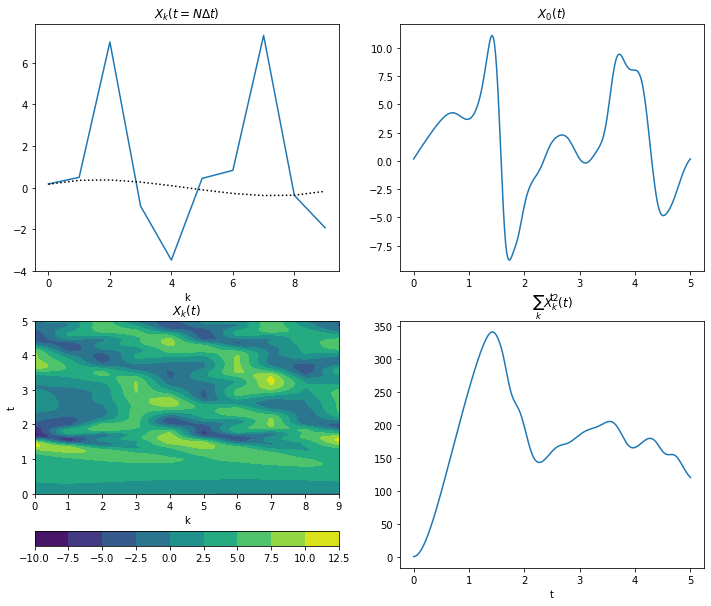

In [5]:
K = 10  # Number of degrees of freedom
nt = 250  # Number of time steps
dt = 0.02  # time step
F = 8.0  # Model parameter

# Initial conditions
k = np.arange(K)  # For coordinate in plots
s = 2 * (0.5 + k) / K - 1  # A symmetric coordinate from -1..+1
Xinit = s * (s - 1) * (s + 1)  # Initial conditions

# "Run" model
X, t = integrate_L96_1t(Xinit, F, dt, nt)

plt.figure(figsize=(12, 10))
plt.subplot(221)
# Snapshot of X[k]
plt.plot(k, X[-1])
plt.xlabel("k")
plt.title("$X_k(t=N\Delta t)$")
plt.plot(k, Xinit, "k:")
plt.subplot(222)
# Sample time-series X[0](t)
plt.plot(t, X[:, 0])
plt.xlabel("t")
plt.title("$X_0(t)$")
plt.subplot(223)
# Full model history
plt.contourf(k, t, X)
plt.colorbar(orientation="horizontal")
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")
plt.subplot(224)
# Metric, total model energy
plt.plot(t, (X**2).sum(axis=-1))
plt.xlabel("t")
plt.title("$\sum_k X_k^2(t)$");

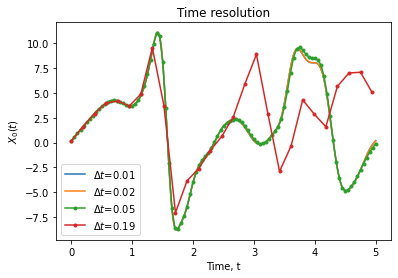

In [6]:
Xrk4_001, t001 = integrate_L96_1t(Xinit, F, 0.01, 500)
Xrk4_002, t002 = integrate_L96_1t(Xinit, F, 0.02, 250)
Xrk4_005, t005 = integrate_L96_1t(Xinit, F, 0.05, 100)
Xrk4_019, t019 = integrate_L96_1t(Xinit, F, 0.19, 26)

plt.plot(t001, Xrk4_001[:, 0], label="$\Delta t$=0.01")
plt.plot(t002, Xrk4_002[:, 0], label="$\Delta t$=0.02")
plt.plot(t005, Xrk4_005[:, 0], ".-", label="$\Delta t$=0.05")
plt.plot(t019, Xrk4_019[:, 0], ".-", label="$\Delta t$=0.19")
plt.legend()
plt.xlabel("Time, t")
plt.ylabel("$X_0(t)$")
plt.title("Time resolution");

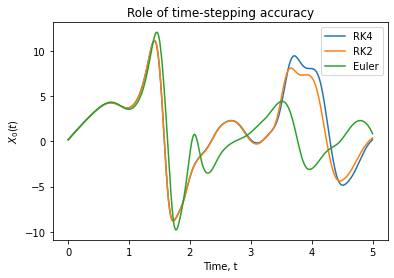

In [7]:
from L96_model import RK2, EulerFwd

dt, nt = 0.01, 500
Xrk4, t = integrate_L96_1t(Xinit, F, dt, nt, method=RK4)
Xrk2, _ = integrate_L96_1t(Xinit, F, dt, nt, method=RK2)
Xef, _ = integrate_L96_1t(Xinit, F, dt, nt, method=EulerFwd)

plt.plot(t, Xrk4[:, 0], label="RK4")
plt.plot(t, Xrk2[:, 0], label="RK2")
plt.plot(t, Xef[:, 0], label="Euler")
plt.legend()
plt.xlabel("Time, t")
plt.ylabel("$X_0(t)$")
plt.title("Role of time-stepping accuracy");

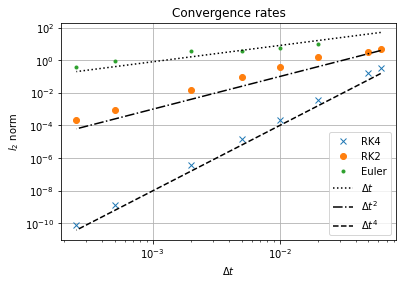

In [8]:
def l2nrm(X, Xtrth):
    return np.sqrt(((X[-1, :] - Xtrth[-1, :]) ** 2).mean())


NT, Lt = [16, 20, 50, 100, 200, 500, 2000, 4000], 3
D, E4, E2, E1 = (
    np.zeros(len(NT)),
    np.zeros(len(NT)),
    np.zeros(len(NT)),
    np.zeros(len(NT)) * np.nan,
)
Xtrth, t = integrate_L96_1t(Xinit, F, 0.25 / NT[-1], Lt * 4 * NT[-1], method=RK4)
for i in range(len(NT)):
    dt = 1.0 / NT[i]
    D[i] = dt
    X, t = integrate_L96_1t(Xinit, F, dt, Lt * NT[i], method=RK4)
    E4[i] = l2nrm(X, Xtrth)
    X, t = integrate_L96_1t(Xinit, F, dt, Lt * NT[i], method=RK2)
    E2[i] = l2nrm(X, Xtrth)
    if dt < 0.04:
        X, t = integrate_L96_1t(Xinit, F, dt, Lt * NT[i], method=EulerFwd)
        E1[i] = l2nrm(X, Xtrth)

plt.loglog(D, E4, "x", label="RK4")
plt.loglog(D, E2, "o", label="RK2")
plt.loglog(D, E1, ".", label="Euler")
plt.loglog(D, 8e2 * D, "k:", label="$\Delta t$")
plt.loglog(D, 1e3 * D**2, "k-.", label="$\Delta t^2$")
plt.loglog(D, 1e4 * D**4, "k--", label="$\Delta t^4$")
plt.legend()
plt.grid()
plt.xlabel("$\Delta t$")
plt.ylabel("$l_2$ norm")
plt.title("Convergence rates");